In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


activities_df = pd.read_csv('data/activities_small.csv', encoding='utf-8')
zero_dist_mask = activities_df['distance'] > 0
activities_df = activities_df[zero_dist_mask]
zero_eg_mask = activities_df['total_elevation_gain'] > 0
activities_df = activities_df[zero_eg_mask]
# activities_df.drop('index', 1, inplace=True)
runs_df = activities_df[activities_df.type == 'Run']
rides_df = activities_df[activities_df.type == 'Ride']

In [13]:
activities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9318 entries, 0 to 9924
Data columns (total 40 columns):
id                        9318 non-null int64
name                      9317 non-null object
distance                  9318 non-null float64
moving_time               9318 non-null float64
elapsed_time              9318 non-null float64
total_elevation_gain      9318 non-null float64
type                      9318 non-null object
start_date                9318 non-null object
start_date_local          9318 non-null object
timezone                  9318 non-null object
achievement_count         9318 non-null int64
kudos_count               9318 non-null int64
comment_count             9318 non-null int64
athlete_count             9318 non-null int64
photo_count               9318 non-null int64
total_photo_count         9318 non-null int64
trainer                   9318 non-null bool
commute                   9318 non-null bool
manual                    9318 non-null bool
private  

Let us focus on the rides dataframe. First lets get out only activities in Colorado. This data frame is relatively small and consists of mostly my ride history. I will have way more once I have scraped more. These are just activities immediately available to me via the strava api.

In [14]:
co_rides_mask = rides_df['state'] == 'Colorado'
co_runs_mask = runs_df['state'] == 'Colorado'
co_rides_df = rides_df[co_rides_mask].reset_index(drop=True).fillna(0)
co_runs_df = runs_df[co_runs_mask].reset_index(drop=True).fillna(0)
print co_rides_df.shape
print co_runs_df.shape

(5738, 40)
(1215, 40)


Now it's time to make clusters of rides with same general starting latitude and longitude, ending latitude and longitude, distance and total elevation gain.

In [15]:
# X = co_rides_df[['distance', 'total_elevation_gain', 'start_lat', 'start_lng']].values
X = co_runs_df[['distance', 'total_elevation_gain', 'start_lat', 'start_lng']].values

In [16]:
k=10
co_runs_df[['distance', 'total_elevation_gain', 'moving_time', 'start_lat', 'start_lng']].head()

,distance,total_elevation_gain,moving_time,start_lat,start_lng
0,11523.2,336.2,5148.0,39.50,-105.38
1,10130.2,335.0,6141.0,39.95,-105.50
2,9725.7,27.6,2761.0,39.68,-104.96
3,26564.5,883.8,11462.0,39.74,-105.37
4,25647.3,1653.0,17173.0,40.00,-105.28


In [17]:
co_runs_df.moving_time.head()

0     5148.0
1     6141.0
2     2761.0
3    11462.0
4    17173.0
Name: moving_time, dtype: float64

Distance and elevation gain in meters. moving time in seconds.

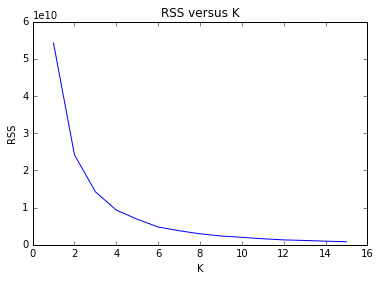

In [18]:
from sklearn.cluster import KMeans
ncluster_list = range(1,16)

def kmean_score(nclust):
    km = KMeans(nclust)
    km.fit(X)
    rss = -km.score(X)
    return rss
scores = [kmean_score(i) for i in range(1,16)]
plt.plot(range(1,16), scores)
plt.xlabel('K')
plt.ylabel('RSS')
plt.title('RSS versus K')
plt.show()

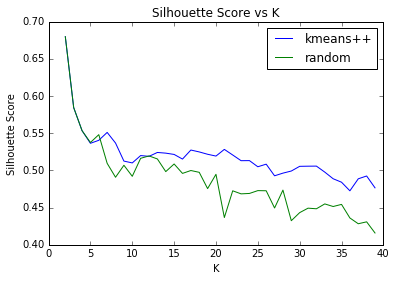

In [19]:
n_samples, n_features = X.shape
def get_silhouette_score(estimator):
    km = estimator
    km.fit(X)
    sil_avg = metrics.silhouette_score(X, km.labels_)
    return sil_avg

def get_estimators(n):
    estimators = [KMeans(init='k-means++', n_clusters=n, n_init=10),
                   KMeans(init='random', n_clusters=n, n_init=10)]
    return estimators

scores_arr = []
for n in range(2, 40):
    sil_scores = [get_silhouette_score(estimator) for estimator in get_estimators(n)]
    scores_arr.append(sil_scores)

plt.plot(range(2, 40), np.array(scores_arr)[:, 0])
plt.plot(range(2, 40), np.array(scores_arr)[:, 1])    
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')
plt.legend(['kmeans++', 'random'])
plt.show()


This method of evaluating the number of clusters always leads to improbable numbers of clusters. With 676 rides in the dataframe(most being mine) it is to be expected that there should be more than 12-16 rides which is number i get which has the silhoutte score on average.

In [20]:
X = StandardScaler().fit_transform(X)

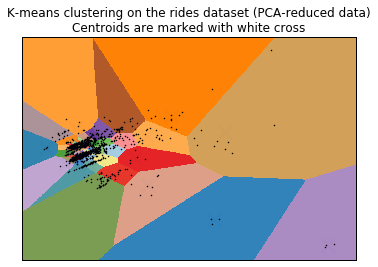

In [21]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='random', n_clusters=50, n_init=10).fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            cmap='prism', zorder=10, alpha=.01)
plt.title('K-means clustering on the rides dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [31]:
from clustering import *
# from setup import *
co_runs_df, co_rides_df, co_runs_clusterer, co_rides_cluster = get_labels(co_runs_df, co_rides_df)
# n_labels = len(co_rides_df.label.unique())
n_labels = len(co_runs_df.label.unique())
# athlete_ids = np.array(sorted(co_rides_df.athlete_id.unique()))
athlete_ids = np.array(sorted(co_rides_df.athlete_id.unique()))
n_athletes = len(athlete_ids)
# co_runs_df = add_closest_city_feature(co_runs_df)
# co_rides_df = add_closest_city_feature(co_rides_df)
# co_rides_df.head()
n_athletes

812

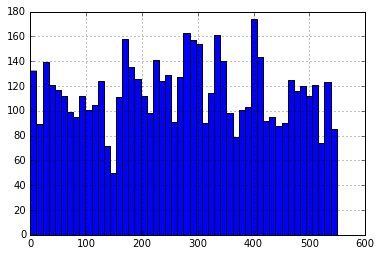

In [23]:
# co_rides_df['label'].hist(bins=50)
co_rides_df['label'].hist(bins=50)
plt.show()

In [24]:
# co_rides_df.groupby(['label', 'closest_city']).count()['id']

The following will be explicitly for the rides dataframe. I am going to assume all methods will work on the runs_df as well.

In [25]:
# ath_labels = co_rides_df.groupby(['athlete_id', 'label']).count()['id'].to_dict()
ath_labels = co_runs_df.groupby(['athlete_id', 'label']).count()['id'].to_dict()

In [26]:
# ath_labels

In [27]:
ratings = np.zeros((n_athletes, n_labels))
for k,v in ath_labels.iteritems():
    ratings[np.where(athlete_ids==k[0])[0][0], k[1]] = v

In [29]:
np.set_printoptions(threshold=5)
ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [20]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 3.89%


Most of this code is from ethan rosenthals blog at: http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/. More to add on this later....

In [21]:
# gordons_rides.groupby('label').count()['id'].sort_values('index', ascending=0).hist(bins=15)
# plt.show()

In [22]:
# gordons_rides = co_rides_df.loc[co_rides_df.athlete_id==7202879, :]
# data = gordons_rides.groupby('label').count()['id'].sort_values('index', ascending=0).values

# from scipy.optimize import curve_fit
# from scipy.misc import factorial


# # get poisson deviated random numbers
# # data = np.random.poisson(2, 1000)

# # the bins should be of integer width, because poisson is an integer distribution
# entries, bin_edges, patches = plt.hist(data, bins=12, range=[-0.5, 15], normed=True)

# # calculate binmiddles
# bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# # poisson function, parameter lamb is the fit parameter
# def poisson(k, lamb):
#     return (lamb**k/factorial(k)) * np.exp(-lamb)

# # fit with curve_fit
# parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# # plot poisson-deviation with fitted parameter
# x_plot = np.linspace(0, 20, 1000)

# plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
# plt.show()
# lam = parameters[0]

In [23]:
# # randomized ratings matrix. Spoofed to remove spacity
# ratings = np.random.poisson(lam=lam, size=(n_athletes, n_labels))

# sparsity = float(len(ratings.nonzero()[0]))
# sparsity /= (ratings.shape[0] * ratings.shape[1])
# sparsity *= 100
# print 'Sparsity: {:4.2f}%'.format(sparsity)

# ratings

In [24]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=True)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

Can't do a train test split with data till there are more ratings per user. When I use the bigger data set this shouldn't be a problem. For the following collaborative filtering model, I will use the entire ratings matrix.

In [25]:
train, test = train_test_split(ratings)

In [26]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [27]:
user_similarity = fast_similarity(ratings, kind='user')
item_similarity = fast_similarity(ratings, kind='item')
print item_similarity[:4, :4]

[[  1.00000000e+00   1.64398987e-01   1.66666667e-01   7.45355992e-11]
 [  1.64398987e-01   1.00000000e+00   1.64398987e-10   7.35214622e-11]
 [  1.66666667e-01   1.64398987e-10   1.00000000e+00   4.47213595e-10]
 [  7.45355992e-11   7.35214622e-11   4.47213595e-10   1.00000000e+00]]


In [131]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [132]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [133]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

User-based CF MSE: 2.51431534371
Item-based CF MSE: 2.30430209806


In [134]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [135]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print 'Top-k User-based CF MSE: ' + str(get_mse(pred, test))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test))

Top-k User-based CF MSE: 2.35012566052
Top-k Item-based CF MSE: 2.28182474732


In [136]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

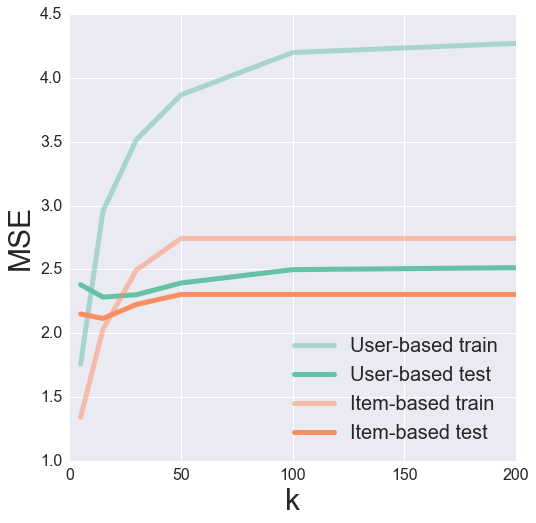

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [138]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [139]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print 'Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test))

item_pred = predict_nobias(train, item_similarity, kind='item')
print 'Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test))

Bias-subtracted User-based CF MSE: 2.25152951538
Bias-subtracted Item-based CF MSE: 2.28600303359


In [140]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [170]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]

user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=30)
user_pred.shape

(178, 50)

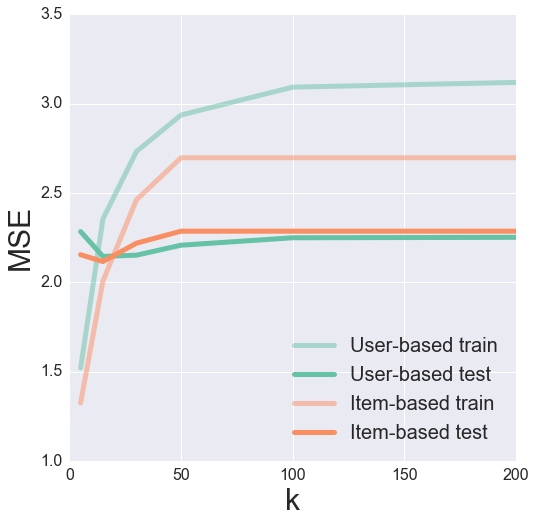

In [142]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [171]:
# idx_to_rides = {}
# df_groupby = co_rides_df.groupby(['label', 'id'])['label'].agg({'Frequency':'count'}).to_dict('series')['Frequency']
# for label in np.sort(co_rides_df['label'].unique()):
#     idx_to_rides[label] = df_groupby[label].index.values

    
idx_to_runs = {}
df_groupby = co_runs_df.groupby(['label', 'id'])['label'].agg({'Frequency':'count'}).to_dict('series')['Frequency']
for label in np.sort(co_runs_df['label'].unique()):
    idx_to_runs[label] = df_groupby[label].index.values

def top_k_labels(similarity, mapper, label_idx, k=3):
    return [mapper[x] for x in np.argsort(similarity[label_idx,:])[:-k-1:-1]]

In [178]:
idx = 32
# rides = top_k_labels(item_similarity, idx_to_rides, idx)
runs = top_k_labels(item_similarity, idx_to_runs, idx)

In [179]:
# rides
item_similarity.shape

(50, 50)

In [180]:
# for activity_id in rides[1]:
#     activity = co_rides_df[co_rides_df['id'] == activity_id].values
#     print "name: {}, distance: {:4.2f} mi, elevation gain: {:4.0f} ft, closest city: {}".format(activity[0, 1], activity[0, 2] * 0.000621371, activity[0, 5] * 3.28084, activity[0, 39])
#     print

for activity_id in runs[0]:
    activity = co_runs_df[co_runs_df['id'] == activity_id].values
    print "name: {}, distance: {:4.2f} mi, elevation gain: {:4.0f} ft, closest city: {}".format(activity[0, 1], activity[0, 2] * 0.000621371, activity[0, 5] * 3.28084, activity[0, 39])
    print

name: 07/28/2014 Evergreen, CO, distance: 5.68 mi, elevation gain: 1083 ft, closest city: Morrison

name: Nice and icy , distance: 5.79 mi, elevation gain:   85 ft, closest city: Louisville

name: Wash Park loop + 1600, 1200, 800, 400, distance: 5.64 mi, elevation gain:    0 ft, closest city: Glendale

name: 05/27/2015 Denver, Colorado, distance: 5.76 mi, elevation gain:  184 ft, closest city: Glendale

name: Huaka - continued morning run, distance: 5.71 mi, elevation gain:  581 ft, closest city: Parker

name: Canyon trot, distance: 5.68 mi, elevation gain:  325 ft, closest city: Boulder

name: Afternoon Run, distance: 5.65 mi, elevation gain: 1456 ft, closest city: Boulder

name: Lion's Lair + Sanitas Valley w/AB, CN, KS, distance: 5.66 mi, elevation gain: 1270 ft, closest city: Boulder

name: NP playing cards, distance: 5.74 mi, elevation gain:   71 ft, closest city: Glendale

name: 08/13/2015 Fountain, Colorado, distance: 5.75 mi, elevation gain:   64 ft, closest city: Fountain

nam

It predicts. Now let's see if we can get a better clustering alogorythm. I started off with k means with 50 clusters. Let's try Agglomerative clustering.

In [227]:
X = co_runs_df[['distance', 'total_elevation_gain', 'moving_time', 'start_lat', 'start_lng']].values

In [246]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

X = StandardScaler().fit_transform(X)
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
ward = AgglomerativeClustering(n_clusters=125, linkage='ward', connectivity=connectivity)

In [247]:
ward.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<1325x1325 sparse matrix of type '<type 'numpy.float64'>'
	with 17486 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=Memory(cachedir=None), n_clusters=125,
            pooling_func=<function mean at 0x10477ad70>)

In [248]:
y_pred = ward.labels_.astype(np.int)
np.mean(np.bincount(y_pred))

10.6

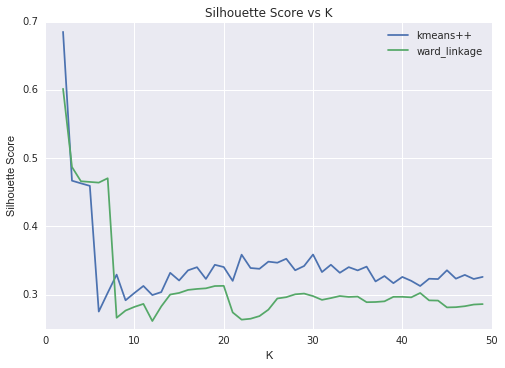

In [195]:
n_samples, n_features = X.shape
def get_silhouette_score(estimator):
    est = estimator
    est.fit(X)
    sil_avg = metrics.silhouette_score(X, est.labels_.astype(np.int))
    return sil_avg

def get_estimators(n):
    estimators = [KMeans(init='k-means++', n_clusters=n, n_init=10), 
                  AgglomerativeClustering(n_clusters=n, linkage='ward', connectivity=connectivity)]
    return estimators

scores_arr = []
for n in range(2, 50):
    sil_scores = [get_silhouette_score(estimator) for estimator in get_estimators(n)]
    scores_arr.append(sil_scores)

plt.plot(range(2, 50), np.array(scores_arr)[:, 0])
plt.plot(range(2, 50), np.array(scores_arr)[:, 1])    
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')
plt.legend(['kmeans++', 'ward_linkage'])
plt.show()

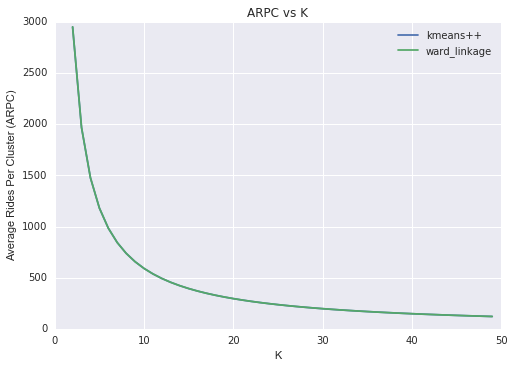

In [217]:
n_samples, n_features = X.shape
def get_avg_pts_per_cluster(estimator):
    estimator.fit(X)
    y_pred = estimator.labels_.astype(np.int)
    return np.mean(np.bincount(y_pred))

def get_estimators(n):
    estimators = [KMeans(init='k-means++', n_clusters=n, n_init=10), 
                  AgglomerativeClustering(n_clusters=n, linkage='ward', connectivity=connectivity)]
    return estimators

scores_arr = []
for n in range(2, 50):
    avg_pts_per_cluster = [get_avg_pts_per_cluster(estimator) for estimator in get_estimators(n)]
    scores_arr.append(avg_pts_per_cluster)

plt.plot(range(2, 50), np.array(scores_arr)[:, 0])
plt.plot(range(2, 50), np.array(scores_arr)[:, 1])    
plt.xlabel('K')
plt.ylabel('Average Rides Per Cluster (ARPC)')
plt.title('ARPC vs K')
plt.legend(['kmeans++', 'ward_linkage'])
plt.show()

In [220]:
scores_arr[0]

[[2951.0, 2951.0],
 [1967.3333333333333, 1967.3333333333333],
 [1475.5, 1475.5],
 [1180.4000000000001, 1180.4000000000001],
 [983.66666666666663, 983.66666666666663],
 [843.14285714285711, 843.14285714285711],
 [737.75, 737.75],
 [655.77777777777783, 655.77777777777783],
 [590.20000000000005, 590.20000000000005],
 [536.5454545454545, 536.5454545454545],
 [491.83333333333331, 491.83333333333331],
 [454.0, 454.0],
 [421.57142857142856, 421.57142857142856],
 [393.46666666666664, 393.46666666666664],
 [368.875, 368.875],
 [347.1764705882353, 347.1764705882353],
 [327.88888888888891, 327.88888888888891],
 [310.63157894736844, 310.63157894736844],
 [295.10000000000002, 295.10000000000002],
 [281.04761904761904, 281.04761904761904],
 [268.27272727272725, 268.27272727272725],
 [256.60869565217394, 256.60869565217394],
 [245.91666666666666, 245.91666666666666],
 [236.08000000000001, 236.08000000000001],
 [227.0, 227.0],
 [218.59259259259258, 218.59259259259258],
 [210.78571428571428, 210.785714